In [7]:
from gurobipy import Model, GRB, quicksum
import random
class VRPSPD:
    def __init__(self, nodes, customer_nodes, vehicles, distance, capacity, pickup, delivery, M1=1000, M2=1000, vehicle_cost=15):
        self.nodes = nodes
        self.customer_nodes = customer_nodes
        self.vehicles = vehicles
        self.K = len(vehicles)
        self.distance = distance
        self.capacity = capacity
        self.pickup = pickup #pickup for each requested node
        self.delivery = delivery #delivery for each requested node
        self.M1 = M1
        self.M2 = M2
        self.vehicle_cost = vehicle_cost
        self.model = Model("VRPSPD")
        self._build_model()

    def _build_model(self):
        # Decision Variables
        self.x = self.model.addVars(self.nodes, self.nodes, vtype=GRB.BINARY, name="x")
        self.y = self.model.addVars(self.vehicles, vtype=GRB.BINARY, name="y")  # Vehicle usage
        self.D = self.model.addVars(self.nodes, vtype=GRB.CONTINUOUS, name="D")  # Delivery load
        self.L = self.model.addVars(self.nodes, vtype=GRB.CONTINUOUS, name="L")  # Total load
        self.lp = self.model.addVars(self.nodes, vtype=GRB.CONTINUOUS, name="lp") #auxillary - pickup load after visiting node i in V



        # Compute M1^{ij} for all i in V, j in C
        M1_ij = {}
        for i in self.nodes:
            for j in self.customer_nodes:
                M1_ij[i, j] = self.capacity - max(0, self.pickup[j] - self.delivery[j])

        # Compute M2^{ij} for all i, j in C
        M2_ij = {}
        for i in self.customer_nodes:
            for j in self.customer_nodes:
                M2_ij[i, j] = self.capacity - max(self.delivery[j], self.delivery[i] - self.pickup[i] + self.delivery[j])

        M3_ij = {}
        for i in self.customer_nodes:
            for j in self.nodes:
                M3_ij[i, j] = self.capacity - max(0, self.delivery[i] - self.pickup[i])

        # Constraints
        for i in self.nodes:
            self.model.addConstr(self.x[i, i] == 0, name=f"no_self_loop_{i}")

        # Each customer is visited exactly once
        for j in self.customer_nodes:
            self.model.addConstr(quicksum(self.x[i, j] for i in self.nodes if i != j) == 1, name=f"leave_once_{j}")
            self.model.addConstr(quicksum(self.x[j, i] for i in self.nodes if i != j) == 1, name=f"approach_once_{j}")
        
        #Limiting number of vehicles k than can leave depot at once
        for i in self.nodes: 
            self.model.addConstr(quicksum(self.x[0, i] for i in self.nodes) <= self.K, name=f'limited exit{self.K}')

    
            #self.model.addConstr(quicksum(self.x[0, i] for i in self.nodes if i != 0) == self.K, name="vehicles_leaving_depot")

            

        for i in self.nodes:
            for j in self.customer_nodes:
                self.model.addConstr(self.D[i] >= self.D[j] + self.delivery[i] - M1_ij[i,j] * (1 - self.x[i, j]), name=f"delivery_consistency_{i}_{j}")
        
        for j in self.customer_nodes: 
            self.model.addConstr(self.L[j] >= self.D[j] - self.delivery[j] + self.pickup[j], name = f'load_consistency_{j}')

        for i in self.customer_nodes: 
            for j in self.customer_nodes: 
                self.model.addConstr(self.L[j] >= self.L[i] - self.delivery[j] + self.pickup[j] - M2_ij[i,j] * (1 - self.x[i, j]), name = f'pickup_consistency_{i}_{j}')

        for i in self.nodes: 
            self.model.addConstr(self.delivery[i] <= self.D[i],  name = 'equation11 constr')
            self.model.addConstr(self.D[i] <= self.capacity, name = 'equation11 pt 2')

        for i in self.customer_nodes: 
            self.model.addConstr(self.pickup[i] <= self.L[i], name = 'equation12 constr')
            self.model.addConstr(self.L[i] <= self.capacity, name = 'equation12 pt 2')
        


        for i in self.customer_nodes: 
            self.model.addConstr(self.L[i] >= 0)
        
        for i in self.nodes: 
            self.model.addConstr(self.D[i] >= 0)
            self.model.addConstr(self.lp[i] >= 0)


    
        for i in self.customer_nodes: 
            self.model.addConstr(self.L[i] <= self.capacity - max(0, self.delivery[i] - self.pickup[i]))
            self.model.addConstr(self.D[i] <= self.capacity - max(0, self.pickup[i] - self.delivery[i]))

                
        for i in self.customer_nodes: 
            for j in self.nodes:
                self.model.addConstr(self.lp[j] >= self.lp[i] + self.pickup[j] - M3_ij[i,j]*(1 - self.x[i,j]))
        
        for i in self.nodes: 
            self.model.addConstr(self.pickup[i] <= self.lp[i])
            self.model.addConstr(self.lp[i] <= self.capacity)

        for i in self.customer_nodes: 
            self.model.addConstr(self.L[i] == self.lp[i] + self.D[i] - self.delivery[i])



    

        # Objective Function
        self.model.setObjective(
            quicksum(self.distance[i, j] * self.x[i, j] for i in self.nodes for j in self.nodes if i != j),
            GRB.MINIMIZE
        )

    def solve(self):
        self.model.optimize()
        if self.model.status == GRB.OPTIMAL:
            return self.get_solution()
        elif self.model.status == GRB.INFEASIBLE:
            print("Model is infeasible. Computing IIS to identify conflicting constraints...")
            self.model.computeIIS()
            self.model.write("model.ilp")
            print("Infeasible constraints written to 'model.ilp'. Review the file to identify conflicts.")
        return None

    def get_solution(self):
        solution = {
            "x": {(i, j): self.x[i, j].x for i in self.nodes for j in self.nodes if self.x[i, j].x > 0.5},
            "y": {k: self.y[k].x for k in self.vehicles if self.y[k].x > 0.5},
            "D": {i: self.D[i].x for i in self.nodes},
            "L": {i: self.L[i].x for i in self.nodes},
            "objective": self.model.objVal
        }
        return solution

In [ ]:
# # Example data
# nodes = [0, 1, 2, 3, 4, 5, 6]
# customer_nodes = [1, 2, 3, 4, 5, 6]
# vehicles = [0, 1, 2]  # 3 vehicles
# #distance = {(i, j): 10 for i in nodes for j in nodes if i != j}
# distance = {(i, j): random.randint(1, 41) for i in nodes for j in nodes if i != j}
# capacity = 140
# pickup = {0:0, 1: 10, 2: 15, 3: 20, 4: 25, 5:22, 6: 24}
# delivery = {0:0, 1: 5, 2: 10, 3: 15, 4: 20, 5: 12, 6: 15}


# import random

# Define dataset parameters
num_nodes = 11
num_vehicles = 3
capacity = 120

# Nodes: depot is 0, others are customers
nodes = list(range(num_nodes))
customer_nodes = nodes[1:]

# Vehicles
vehicles = list(range(num_vehicles))

# Random distance cost for each arc (excluding self-loops)
distance = {(i, j): random.randint(1, 41) for i in nodes for j in nodes if i != j}

# Random pickup and delivery values (depot remains 0)
pickup = {0: 0, **{i: random.randint(0, 66) for i in customer_nodes}}
delivery = {0: 0, **{i: random.randint(0, 20) for i in customer_nodes}}

# Print dataset for verification
print("Nodes:", nodes)
print("Vehicles:", vehicles)
print("Pickup:", pickup)
print("Delivery:", delivery)


# Create and solve the model
vrp = VRPSPD(nodes, customer_nodes, vehicles, distance, capacity, pickup, delivery)
vrp.solve()

# Verify the solution
#verify_vrpspd(vrp)

Nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Vehicles: [0, 1, 2]
Pickup: {0: 0, 1: 19, 2: 43, 3: 53, 4: 49, 5: 22, 6: 49, 7: 43, 8: 3, 9: 57}
Delivery: {0: 0, 1: 10, 2: 6, 3: 13, 4: 13, 5: 6, 6: 5, 7: 4, 8: 16, 9: 5}
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 10.0 (19045.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-1255U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Academic license 2632106 - for non-commercial use only - registered to a.___@student.tudelft.nl
Optimize a model with 422 rows, 133 columns and 1151 nonzeros
Model fingerprint: 0xab64d825
Variable types: 30 continuous, 103 integer (103 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Presolve removed 178 rows and 25 columns
Presolve time: 0.00s
Presolved: 244 rows, 108 columns, 1678 nonzeros
Variable types: 27 continuous, 81

{'x': {(0, 2): 1.0,
  (0, 6): 1.0,
  (0, 8): 1.0,
  (1, 4): 1.0,
  (2, 5): 1.0,
  (3, 0): 1.0,
  (4, 0): 1.0,
  (5, 3): 1.0,
  (6, 1): 1.0,
  (7, 0): 1.0,
  (8, 9): 1.0,
  (9, 7): 1.0},
 'y': {},
 'D': {0: 120.0,
  1: 23.0,
  2: 25.0,
  3: 13.0,
  4: 13.0,
  5: 19.0,
  6: 28.0,
  7: 4.0,
  8: 25.0,
  9: 9.0},
 'L': {0: 0.0,
  1: 81.0,
  2: 62.0,
  3: 118.0,
  4: 117.0,
  5: 78.0,
  6: 72.0,
  7: 103.0,
  8: 12.0,
  9: 64.0},
 'objective': 120.0}

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 10.0 (19045.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-1255U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Academic license 2632106 - for non-commercial use only - registered to a.___@student.tudelft.nl
Optimize a model with 422 rows, 133 columns and 1151 nonzeros
Model fingerprint: 0xab64d825
Variable types: 30 continuous, 103 integer (103 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Presolved: 244 rows, 108 columns, 1678 nonzeros

Continuing optimization...


Cutting planes:
  Learned: 2
  Cover: 7
  Implied bound: 22
  Clique: 2
  MIR: 13
  Zero half: 2
  RLT: 2
  Relax-and-lift: 7
  BQP: 1

Explored 277 nodes (3810 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 12 (of 12 available processors)

Solution c

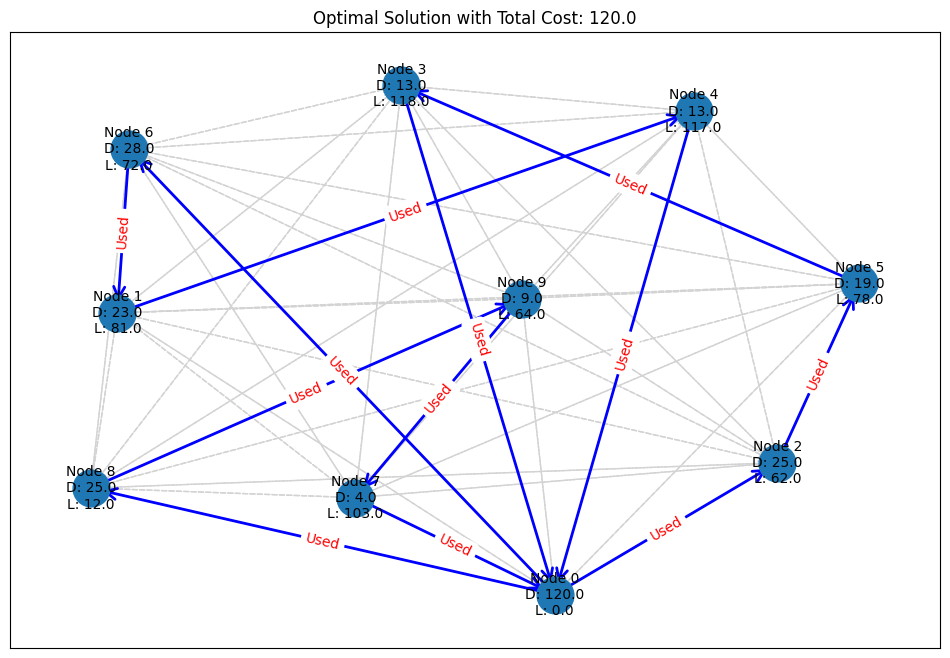

In [9]:
import networkx as nx
import matplotlib.pyplot as plt

# Solve the VRP and get the solution
solution = vrp.solve()

if solution is None:
    print("No valid solution found.")
else:
    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes with attributes
    for node in solution['D']:
        G.add_node(node, delivery=solution['D'][node], total_load=solution['L'][node])

    # Add all possible edges (arcs) with a default style
    all_edges = [(i, j) for i in solution['D'] for j in solution['D'] if i != j]
    G.add_edges_from(all_edges)

    # Add edges used in the solution
    used_edges = [(i, j) for (i, j), value in solution['x'].items() if value > 0.5]

    # Position nodes for visualization
    pos = nx.spring_layout(G)

    plt.figure(figsize=(12, 8))

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=700)

    # Draw all edges (light gray, dashed)
    nx.draw_networkx_edges(G, pos, edgelist=all_edges, edge_color='lightgray', width=1, style='dashed', arrowstyle='->', arrowsize=10)

    # Draw edges used in the solution (highlighted in blue)
    nx.draw_networkx_edges(G, pos, edgelist=used_edges, edge_color='b', width=2, arrowstyle='->', arrowsize=20)

    # Draw node labels
    node_labels = {node: f"Node {node}\nD: {data['delivery']}\nL: {data['total_load']}" for node, data in G.nodes(data=True)}
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10, font_color='black')

    # Draw edge labels
    edge_labels = {(i, j): f"Used" for (i, j) in used_edges}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

    # Display the graph
    plt.title(f"Optimal Solution with Total Cost: {solution['objective']}")
    plt.show()



Optimal Solution Found:
x[0,0]: 0.0
x[0,1]: -0.0
x[0,2]: 1.0
x[0,3]: -0.0
x[0,4]: -0.0
x[0,5]: -0.0
x[0,6]: 1.0
x[0,7]: -0.0
x[0,8]: 1.0
x[0,9]: -0.0
x[1,0]: 0.0
x[1,1]: 0.0
x[1,2]: -0.0
x[1,3]: -0.0
x[1,4]: 1.0
x[1,5]: -0.0
x[1,6]: -0.0
x[1,7]: -0.0
x[1,8]: -0.0
x[1,9]: -0.0
x[2,0]: 0.0
x[2,1]: -0.0
x[2,2]: 0.0
x[2,3]: -0.0
x[2,4]: -0.0
x[2,5]: 1.0
x[2,6]: -0.0
x[2,7]: -0.0
x[2,8]: -0.0
x[2,9]: -0.0
x[3,0]: 1.0
x[3,1]: -0.0
x[3,2]: -0.0
x[3,3]: 0.0
x[3,4]: -0.0
x[3,5]: -0.0
x[3,6]: -0.0
x[3,7]: -0.0
x[3,8]: -0.0
x[3,9]: -0.0
x[4,0]: 1.0
x[4,1]: -0.0
x[4,2]: -0.0
x[4,3]: -0.0
x[4,4]: 0.0
x[4,5]: -0.0
x[4,6]: -0.0
x[4,7]: -0.0
x[4,8]: -0.0
x[4,9]: -0.0
x[5,0]: 0.0
x[5,1]: -0.0
x[5,2]: -0.0
x[5,3]: 1.0
x[5,4]: -0.0
x[5,5]: 0.0
x[5,6]: -0.0
x[5,7]: -0.0
x[5,8]: -0.0
x[5,9]: -0.0
x[6,0]: 0.0
x[6,1]: 1.0
x[6,2]: -0.0
x[6,3]: -0.0
x[6,4]: -0.0
x[6,5]: -0.0
x[6,6]: 0.0
x[6,7]: -0.0
x[6,8]: -0.0
x[6,9]: -0.0
x[7,0]: 1.0
x[7,1]: -0.0
x[7,2]: -0.0
x[7,3]: -0.0
x[7,4]: -0.0
x[7,5]: -0.0
x[7,6]: 

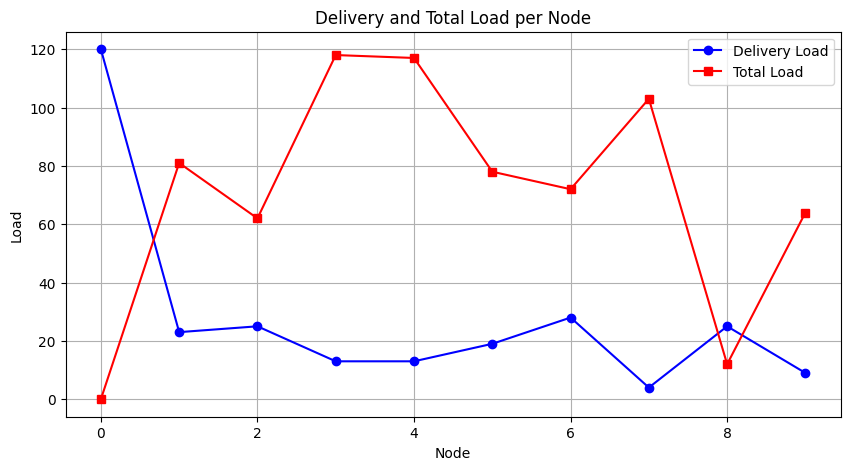

In [10]:
import matplotlib.pyplot as plt 
if vrp.model.status == GRB.OPTIMAL:
    print("\nOptimal Solution Found:")
    for var in vrp.model.getVars():
        print(f"{var.varName}: {var.x}")
    print(f"\nObjective Value: {vrp.model.objVal}")



def plot_loads(solution):
    if solution is None:
        print("No valid solution found.")
        return

    delivery_values = [solution["D"][i] for i in sorted(solution["D"].keys())]
    total_load_values = [solution["L"][i] for i in sorted(solution["L"].keys())]
    nodes = sorted(solution["D"].keys())

    plt.figure(figsize=(10, 5))

    plt.plot(nodes, delivery_values, marker='o', linestyle='-', label="Delivery Load", color='blue')
    plt.plot(nodes, total_load_values, marker='s', linestyle='-', label="Total Load", color='red')

    plt.xlabel("Node")
    plt.ylabel("Load")
    plt.title("Delivery and Total Load per Node")
    plt.legend()
    plt.grid()
    plt.show()


plot_loads(vrp.solve())





Distance Matrix:

    0   1   2   3   4
0   X  23  30   9   6
1  23   X  40  32  34
2  30  40   X  50  38
3   9  32  50   X  32
4   6  34  38  32   X
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 10.0 (19045.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-1255U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Academic license 2632106 - for non-commercial use only - registered to a.___@student.tudelft.nl
Optimize a model with 62 rows, 35 columns and 137 nonzeros
Model fingerprint: 0xc9f16d16
Variable types: 10 continuous, 25 integer (25 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [6e+00, 5e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Found heuristic solution: objective 164.0000000
Presolve removed 29 rows and 11 columns
Presolve time: 0.00s
Presolved: 33 rows, 24 columns, 152 nonzeros
Variable types: 8 continuous, 16 integer (16 binary)


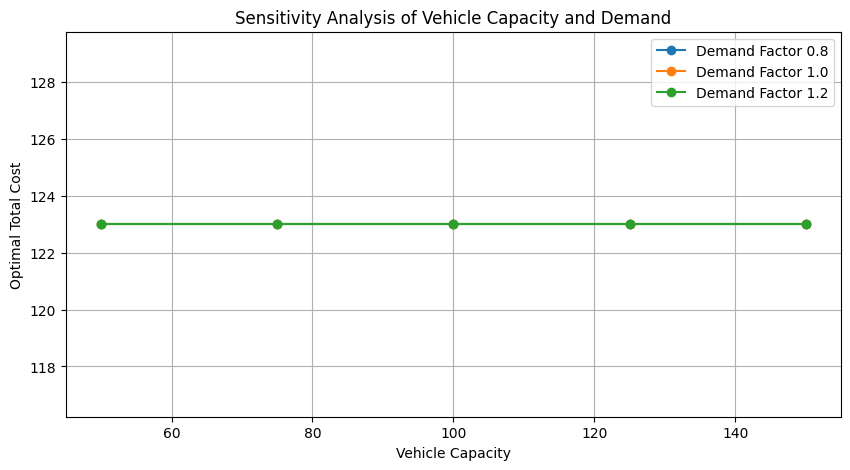

In [11]:
import gurobipy as gp
from gurobipy import GRB, quicksum
import pandas as pd
import matplotlib.pyplot as plt
import random

def run_sensitivity_analysis():
    # Define sets
    nodes = [0, 1, 2, 3, 4]  # 0 is the depot
    customer_nodes = [1, 2, 3, 4]
    vehicles = [0, 1]  # Two vehicles

    # Base Case Data
    base_capacity = 100  # Vehicle capacity
    base_pickup = {1: 10, 2: 15, 3: 20, 4: 25 , 5: 30, 6:35}
    base_delivery = {1: 5, 2: 10, 3: 15, 4: 20 , 5: 25, 6:30}
    distance = {(i, j): random.randint(5, 50) for i in nodes for j in nodes if i != j}
    
    # Make it symmetric
    for i, j in list(distance.keys()):
        distance[j, i] = distance[i, j]

    # Create DataFrame for better display
    distance_matrix = pd.DataFrame(index=nodes, columns=nodes)

    # Fill the matrix
    for i in nodes:
        for j in nodes:
            if i == j:
                distance_matrix.loc[i, j] = "X"  # No self-loops
            else:
                distance_matrix.loc[i, j] = distance[i, j]

    print("\nDistance Matrix:\n")
    print(distance_matrix)


    # Test Scenarios
    capacities = [50, 75, 100, 125, 150]  # Sensitivity on capacity
    demand_factors = [0.8, 1.0, 1.2]  # Sensitivity on pickup & delivery (80%, 100%, 120%)
    
    results = []

    for capacity in capacities:
        for factor in demand_factors:
            # Adjust demand
            pickup = {k: int(base_pickup[k] * factor) for k in base_pickup}
            delivery = {k: int(base_delivery[k] * factor) for k in base_delivery}

            # Initialize the model
            model = gp.Model("VRPSPD_Sensitivity")

            # Decision Variables
            x = model.addVars(nodes, nodes, vtype=GRB.BINARY, name="x")
            D = model.addVars(nodes, vtype=GRB.CONTINUOUS, name="D")
            L = model.addVars(nodes, vtype=GRB.CONTINUOUS, name="L")

            # Constraints
            for i in nodes:
                model.addConstr(x[i, i] == 0, name=f"no_self_loop_{i}")

            for j in customer_nodes:
                model.addConstr(quicksum(x[i, j] for i in nodes if i != j) == 1, name=f"leave_once_{j}")
                model.addConstr(quicksum(x[j, i] for i in nodes if i != j) == 1, name=f"approach_once_{j}")

            model.addConstr(quicksum(x[0, i] for i in customer_nodes) <= len(vehicles), name="limit_vehicles")

            for i in customer_nodes:
                for j in customer_nodes:
                    model.addConstr(D[i] >= D[j] + delivery[i] - 1000 * (1 - x[i, j]), name=f"delivery_consistency_{i}_{j}")
                    model.addConstr(L[j] >= L[i] - delivery[j] + pickup[j] - 1000 * (1 - x[i, j]), name=f"load_transfer_{i}_{j}")

            for i in customer_nodes:
                model.addConstr(delivery[i] <= D[i], name=f"delivery_feasibility_{i}")
                model.addConstr(D[i] <= capacity, name=f"capacity_limit_D_{i}")
                model.addConstr(pickup[i] <= L[i], name=f"pickup_feasibility_{i}")
                model.addConstr(L[i] <= capacity, name=f"capacity_limit_L_{i}")

            # Objective: Minimize total distance
            model.setObjective(quicksum(distance[i, j] * x[i, j] for i in nodes for j in nodes if i != j), GRB.MINIMIZE)

            # Solve Model
            model.optimize()

            # Store Results
            if model.status == GRB.OPTIMAL:
                results.append({
                    "Capacity": capacity,
                    "Demand Factor": factor,
                    "Optimal Cost": model.objVal
                })

    # Convert results to DataFrame
    df_results = pd.DataFrame(results)

    print(df_results)


    # Plot Results
    plt.figure(figsize=(10, 5))
    for factor in demand_factors:
        subset = df_results[df_results["Demand Factor"] == factor]
        plt.plot(subset["Capacity"], subset["Optimal Cost"], marker='o', label=f"Demand Factor {factor}")

    plt.xlabel("Vehicle Capacity")
    plt.ylabel("Optimal Total Cost")
    plt.title("Sensitivity Analysis of Vehicle Capacity and Demand")
    plt.legend()
    plt.grid(True)
    plt.show()

# Run the sensitivity analysis
run_sensitivity_analysis()



Distance Matrix:

    0   1   2   3   4   5   6
0   X  48  13  47  14  42  41
1  48   X  23  17  43  29  34
2  13  23   X  44  35  20  15
3  47  17  44   X  27  23  31
4  14  43  35  27   X  29  10
5  42  29  20  23  29   X  35
6  41  34  15  31  10  35   X
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 10.0 (19045.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-1255U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Academic license 2632106 - for non-commercial use only - registered to a.___@student.tudelft.nl
Optimize a model with 116 rows, 63 columns and 301 nonzeros
Model fingerprint: 0x834eedab
Variable types: 14 continuous, 49 integer (49 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [1e+01, 5e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Presolve removed 43 rows and 15 columns
Presolve time: 0.00s
Presolved: 73 rows, 48 columns, 492 n

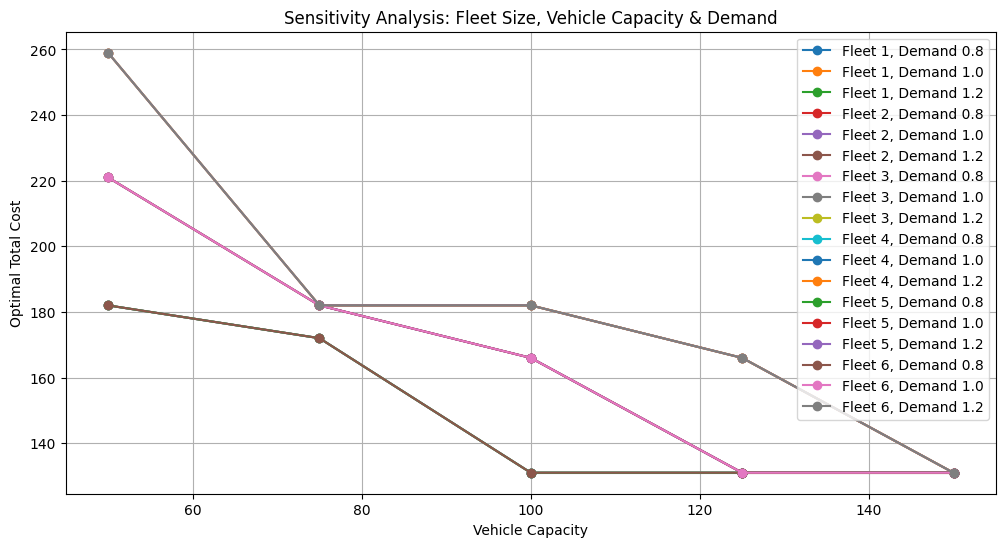

In [12]:
import gurobipy as gp
from gurobipy import GRB, quicksum
import pandas as pd
import matplotlib.pyplot as plt
import random

def extended_sensitivity_analysis():
    # Define sets
    nodes = [0, 1, 2, 3, 4 ,5 ,6]  # 0 is the depot
    customer_nodes = [1, 2, 3, 4 ,5 ,6]

    # Base Case Data
    base_capacity = 100  # Vehicle capacity
    base_pickup = {1: 10, 2: 15, 3: 20, 4: 25, 5: 30, 6: 35}
    base_delivery = {1: 5, 2: 10, 3: 15, 4: 20, 5: 25, 6: 30}
    #distance = {(i, j): 10 for i in nodes for j in nodes if i != j}
    distance = {(i, j): random.randint(5, 50) for i in nodes for j in nodes if i != j}

    # Make it symmetric
    for i, j in list(distance.keys()):
        distance[j, i] = distance[i, j]

    # Create DataFrame for better display
    distance_matrix = pd.DataFrame(index=nodes, columns=nodes)

    # Fill the matrix
    for i in nodes:
        for j in nodes:
            if i == j:
                distance_matrix.loc[i, j] = "X"  # No self-loops
            else:
                distance_matrix.loc[i, j] = distance[i, j]

    print("\nDistance Matrix:\n")
    print(distance_matrix)
    
    # Test Scenarios
    capacities = [50, 75, 100, 125, 150]  # Sensitivity on capacity
    demand_factors = [0.8, 1.0, 1.2]  # Sensitivity on demand
    fleet_sizes = [1, 2, 3, 4, 5,6]  # Number of vehicles available

    results = []

    for K in fleet_sizes:
        for capacity in capacities:
            for factor in demand_factors:
                # Adjust demand
                pickup = {k: int(base_pickup[k] * factor) for k in base_pickup}
                delivery = {k: int(base_delivery[k] * factor) for k in base_delivery}

                if capacity < max(delivery.values()) or capacity < max(pickup.values()):
                    continue

                # Initialize the model
                model = gp.Model("VRPSPD_Fleet_Sensitivity")

                # Decision Variables
                x = model.addVars(nodes, nodes, vtype=GRB.BINARY, name="x")
                D = model.addVars(nodes, vtype=GRB.CONTINUOUS, name="D")
                L = model.addVars(nodes, vtype=GRB.CONTINUOUS, name="L")

                # Constraints
                for i in nodes:
                    model.addConstr(x[i, i] == 0, name=f"no_self_loop_{i}")

                for j in customer_nodes:
                    model.addConstr(quicksum(x[i, j] for i in nodes if i != j) == 1, name=f"leave_once_{j}")
                    model.addConstr(quicksum(x[j, i] for i in nodes if i != j) == 1, name=f"approach_once_{j}")

                model.addConstr(quicksum(x[0, i] for i in customer_nodes) <= K, name="limit_vehicles")

                for i in customer_nodes:
                    for j in customer_nodes:
                        model.addConstr(D[i] >= D[j] + delivery[i] - 1000 * (1 - x[i, j]), name=f"delivery_consistency_{i}_{j}")
                        model.addConstr(L[j] >= L[i] - delivery[j] + pickup[j] - 1000 * (1 - x[i, j]), name=f"load_transfer_{i}_{j}")

                for i in customer_nodes:
                    model.addConstr(delivery[i] <= D[i], name=f"delivery_feasibility_{i}")
                    model.addConstr(D[i] <= capacity, name=f"capacity_limit_D_{i}")
                    model.addConstr(pickup[i] <= L[i], name=f"pickup_feasibility_{i}")
                    model.addConstr(L[i] <= capacity, name=f"capacity_limit_L_{i}")

                # Objective: Minimize total distance
                model.setObjective(quicksum(distance[i, j] * x[i, j] for i in nodes for j in nodes if i != j), GRB.MINIMIZE)

                # Solve Model
                model.optimize()

                # Store Results
                if model.status == GRB.OPTIMAL:
                    results.append({
                        "Fleet Size": K,
                        "Capacity": capacity,
                        "Demand Factor": factor,
                        "Optimal Cost": model.objVal
                    })

    # Convert results to DataFrame
    df_results = pd.DataFrame(results)

    df_results.to_csv("sensitivity_analysis_results.csv", index=False)
    print("Results saved to sensitivity_analysis_results.csv")

    # Print table
    print(df_results)

    # Plot Results
    plt.figure(figsize=(12, 6))
    for K in fleet_sizes:
        subset = df_results[df_results["Fleet Size"] == K]
        for factor in demand_factors:
            data = subset[subset["Demand Factor"] == factor]
            plt.plot(data["Capacity"], data["Optimal Cost"], marker='o', linestyle='-', label=f"Fleet {K}, Demand {factor}")

    plt.xlabel("Vehicle Capacity")
    plt.ylabel("Optimal Total Cost")
    plt.title("Sensitivity Analysis: Fleet Size, Vehicle Capacity & Demand")
    plt.legend()
    plt.grid(True)
    plt.show()

# Run the extended sensitivity analysis
extended_sensitivity_analysis()